# Practico Exploracion y curacion

-----

## Consignas

### 1. Curación de datos anómalos

Existe una cantidad de datos anómalos en el dataset y es necesario curarlos. Elegir y justificar una estrategia de imputación para los datos nulos.

### 2. Eliminación de outliers: 

En base en el estudio de outliers hecho en el practico 1, definan cotas inferiores y superiores para las variables que presenten outliers y filtren las filas que no cumplan con esos limites.

### 3. Balanceo de etiquetas:

La etiqueta positiva esta desbalanceada con respecto a la negativa. Esto se vio en el análisis de distribución sobre las distintas variables con respecto a la etiqueta. Existen distintos métodos para balanceo de etiquetas (ver notebooks over_sampling y under_sampling) así que vamos a probar algunos para ayudar a nuestros modelos del practico que viene.

- Usar al menos tres métodos de over-sampling para balancear el target. Uno de ellos tiene que ser RandomOverSampler
- Usar al menos tres métodos de under-sampling para balancear el target. Uno de ellos tiene que ser RandomUnderSampler

### 4. Escalado

Todas las métricas provenientes de la teoría de la información con excepción de ZE están escaladas entre 0 y 1. Es decir que tienen un mínimo en 0 y máximo en 1. Es necesario que todas nuestras features tengan la misma escala para que los modelos de ML funcionen mejor. Escalar LZE y las métricas de estadística clásica (media, varianza, skew) entre 0 y 1. (hint: MinMaxScaler)

Exporten en csv, o en algun formato de preferencia, el dataset escalado

### 5. PCA

Realizar PCA sobre el dataset original y acoplar las columnas generadas mas significativas al dataset.

### Referencias

PCA: https://towardsdatascience.com/principal-component-analysis-3c39fbf5cb9d

Etiquetas no balanceadas: https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7#:~:text=3.%20Resampling%20to,imbalanced%2Dlearn%20library

imbalanced-learn: https://github.com/scikit-learn-contrib/imbalanced-learn

### 6. Ejercicio opcional: Analizando la columna GNE en busqueda de Mezclas Gaussianas

Dada la grafica de la distribucion de la columna que contiene esta metrica, podriamos inferir que se trata de una distribucion bimodal. Podemos intentar separar estas distribuciones usando el algoritmo Expectation-Maximization: https://scikit-learn.org/stable/modules/mixture.html#expectation-maximization 

La principal dificultad en modelar distribuciones bimodales o multimodales radica en diferenciar los puntos que pertenecen a los distintos componentes latentes. Expectation-Maximization hace un proceso iterativo para abordar ese problema. Primero asume componentes (medias o centros) aleatorias (o aprendidas con k-means), y luego computa para cada punto una probabilidad de haber sido generado por cada uno de los componentes del modelo. Luego, se modifican los parametros para alcanzar la maxima verosimilitud de los datos. Repitiendo este proceso se garantiza una convergencia. 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from scipy import linalg
from sklearn import mixture

sns.set_style("darkgrid")

<AxesSubplot:xlabel='GNE', ylabel='Count'>

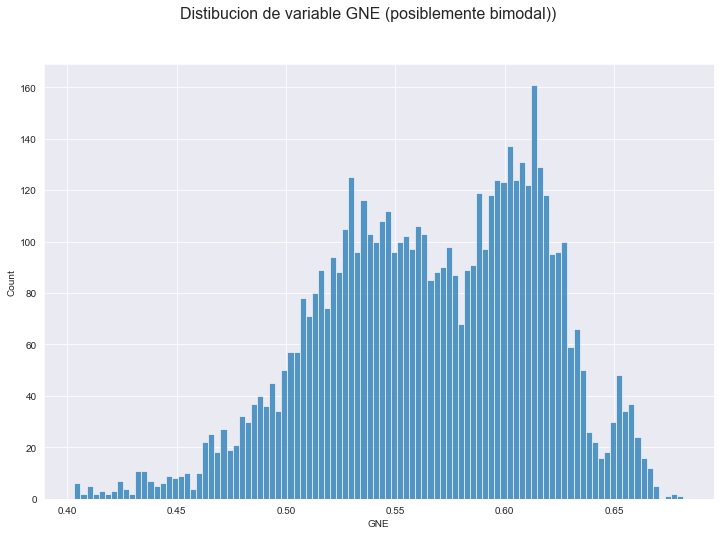

In [ ]:
# Obtenemos los datos

df_etiquetados = []
df_no_etiquetados = []
filedir = "/home/floormolina99/DiploDatos/Mentoria/data_preprocessed"

from os import listdir

for file in listdir(filedir):
    if file[-4:] == ".csv":
        if "noEtiquetado" in file: df_no_etiquetados.append(pd.read_csv(f"{filedir}/{file}"))
        else: df_etiquetados.append(pd.read_csv(f"{filedir}/{file}"))
    else: print(file, " ---> no es csv")

for df in df_etiquetados: assert len(df.columns) == 11
for df in df_no_etiquetados: assert len(df.columns) == 10
    
df = pd.concat(df_etiquetados)

# Definir outliers segun los limites establecidos luego de analisis de practico 1
low_outlier_limit = 0.4
top_outlier_limit = 0.7

fig = plt.figure(figsize=(12,8))
fig.suptitle("Distibucion de variable GNE (posiblemente bimodal))", fontsize=16)
sns.histplot(df[(df["GNE"] > low_outlier_limit) & (df["GNE"] < top_outlier_limit)]["GNE"], bins=100)

<AxesSubplot:xlabel='data', ylabel='Count'>

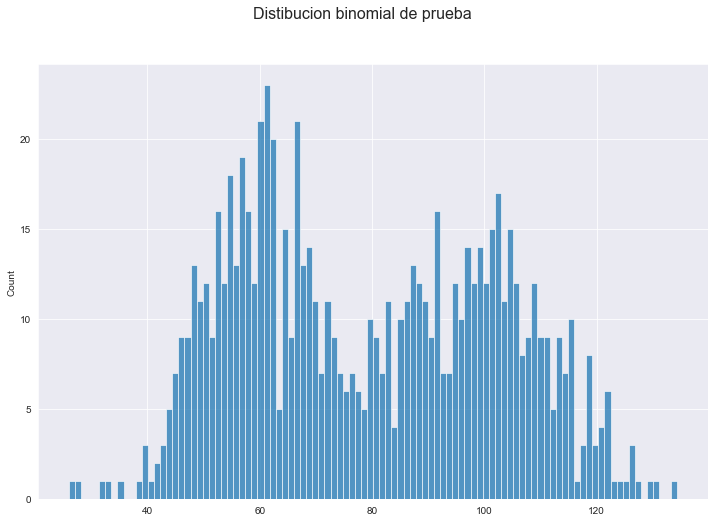

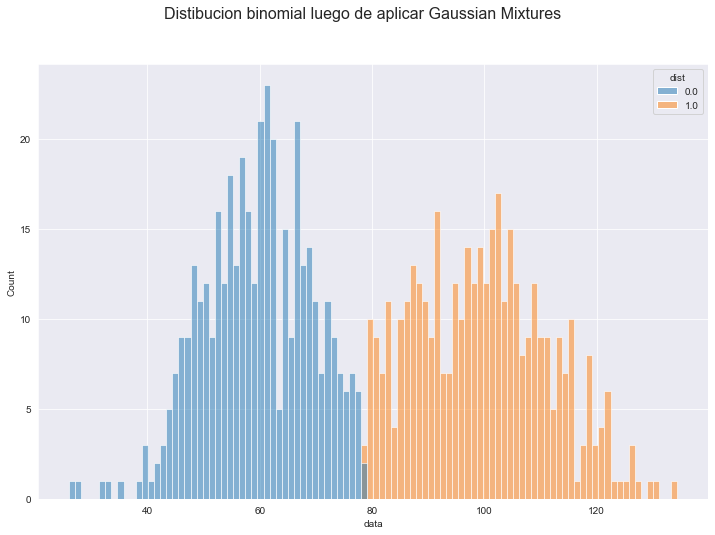

In [ ]:
# Ditribucion bimodal de prueba (Reemplazar con GNE)

N=400
mu, sigma = 100, 13
mu2, sigma2 = 60, 10
X1 = np.random.normal(mu, sigma, N)
X2 = np.random.normal(mu2, sigma2, N)
X = np.concatenate([X1, X2])
fig = plt.figure(figsize=(12,8))
fig.suptitle("Distibucion binomial de prueba", fontsize=16)
sns.histplot(X, bins=100)

X = X.reshape(-1,1)

# Estimamos los centros usando el modelo de mezclas gaussianas, que internamente usa Expectation-Maximization
gmm = mixture.GaussianMixture(
            n_components=2, 
            covariance_type="spherical",
            init_params='kmeans'
        )
gmm.fit(X)

# Las predicciones emparejan un punto con un componente
bmod = np.column_stack((X,gmm.predict(X)))
bmod = pd.DataFrame(bmod, columns=["data", "dist"])

fig = plt.figure(figsize=(12,8))
fig.suptitle("Distibucion binomial luego de aplicar Gaussian Mixtures", fontsize=16)
sns.histplot(data=bmod, x = "data", hue="dist", bins=100)

Consignas:
- Aplicar GaussianMixtures sobre la columna GNE de la misma manera que hacemos en este ejemplo. Encontrar hiperparametros que se ajusten mejor a los datos de GNE (Ayudarse con la visualizacion de las distribuciones obtenidas) https://scikit-learn.org/stable/modules/generated/sklearn.mixture.GaussianMixture.html#sklearn.mixture.GaussianMixture
- Incluir en el dataset original las etiquetas que determinan la distribucion a la que pertenece cada punto de GNE.

------------------------------------
### Ejercicio 1: curación de datos anómalos

Cargamos los archivos de datos preprocesados y agrupamos por datos etiquetados y no etiquetados, al igual que con el primer práctico.

In [ ]:
ne_p1 = pd.read_csv('/home/floormolina99/DiploDatos/Mentoria/data_preprocessed/Data_noEtiquetado_P1.csv')
ne_p2 = pd.read_csv('/home/floormolina99/DiploDatos/Mentoria/data_preprocessed/Data_noEtiquetado_P2.csv')
ne_p3 = pd.read_csv('/home/floormolina99/DiploDatos/Mentoria/data_preprocessed/Data_noEtiquetado_P3.csv')
e_p1 = pd.read_csv('/home/floormolina99/DiploDatos/Mentoria/data_preprocessed/Data_test_P1.csv')
e_p2 = pd.read_csv('/home/floormolina99/DiploDatos/Mentoria/data_preprocessed/Data_test_P2.csv')
e_p3 = pd.read_csv('/home/floormolina99/DiploDatos/Mentoria/data_preprocessed/Data_test_P3.csv')

In [ ]:
etiquetados = pd.concat([e_p1,e_p2,e_p3]).reset_index(drop=True)
etiquetados = etiquetados.sample(frac=1)
etiquetados = etiquetados.reset_index(drop=True)
print(len(etiquetados.index))
etiquetados.head()

6042


,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,3.0,0.0,0.499315,0.280421,0.501921,0.404962,0.185327,0.718055,-0.000041,43.810637,-0.017801
1,3.0,0.0,0.508953,0.282583,0.519318,0.474590,0.264553,0.726849,-0.000007,37.444776,0.026498
2,2.0,1.0,0.576361,0.285749,0.628396,0.589248,0.386171,0.784421,0.000009,34.559869,-0.146634
3,3.0,0.0,0.506325,0.282280,0.514978,0.471090,0.256152,0.724558,-0.000011,37.688472,-0.015519
4,2.0,0.0,0.469872,0.278265,0.455221,0.568015,0.243650,0.696110,0.000002,32.317613,-0.247335


In [ ]:
no_etiquetados = pd.concat([ne_p1,ne_p2,ne_p3]).reset_index(drop=True)
no_etiquetados = no_etiquetados.sample(frac=1)
no_etiquetados = no_etiquetados.reset_index(drop=True)
print(len(no_etiquetados.index))
no_etiquetados.head()

6119


,Patient,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,3.0,0.510086,0.281286,0.519508,0.426647,0.207263,0.726938,0.000016,52.512041,-0.009589
1,1.0,0.594235,0.286125,0.656725,0.550525,0.354540,0.799512,-0.000004,15.705856,-0.046915
2,2.0,0.573544,0.286440,0.624437,0.586007,0.382471,0.782315,-0.000011,29.271733,-0.308219
3,1.0,0.501869,0.279884,0.505593,0.422905,0.177014,0.719823,0.000022,74.617798,-0.103011
4,3.0,0.513773,0.282050,0.525890,0.457150,0.238484,0.729944,0.000013,42.535787,0.036174


In [ ]:
no_etiquetados.isnull().sum()

Patient     0
PE          0
SC          0
GNE         0
SE         80
LZC         0
STE         0
Mean        0
Std         0
Skew        0
dtype: int64

In [ ]:
etiquetados.isnull().sum()

Patient     0
State       0
PE          0
SC          0
GNE         0
SE         71
LZC         0
STE         0
Mean        0
Std         0
Skew        0
dtype: int64

Vemos que hay un total de 71 datos nulos en una sola columna para los datos etiquetados y 80 para los etiquetados. Las otras features no tienen problemas de este tipo, por lo que no consideramos que a priori sean un problema. Dado que estos datos constituyen apenas el 1.18% del dataset de datos etiquetados y el 1.31% del total de no etiquetados, consideramos que utilizar alguna tecnica de imputación de datos faltantes es innecesario, y que el mejor curso de acción seria eliminarlos de los datasets.

In [ ]:
etiquetados = etiquetados.dropna(axis=0)
print(len(etiquetados.index))
etiquetados.head()

5971


,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,3.0,0.0,0.499315,0.280421,0.501921,0.404962,0.185327,0.718055,-0.000041,43.810637,-0.017801
1,3.0,0.0,0.508953,0.282583,0.519318,0.474590,0.264553,0.726849,-0.000007,37.444776,0.026498
2,2.0,1.0,0.576361,0.285749,0.628396,0.589248,0.386171,0.784421,0.000009,34.559869,-0.146634
3,3.0,0.0,0.506325,0.282280,0.514978,0.471090,0.256152,0.724558,-0.000011,37.688472,-0.015519
4,2.0,0.0,0.469872,0.278265,0.455221,0.568015,0.243650,0.696110,0.000002,32.317613,-0.247335


In [ ]:
no_etiquetados = no_etiquetados.dropna(axis=0)
print(len(no_etiquetados.index))
no_etiquetados.head()

6039


,Patient,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,3.0,0.510086,0.281286,0.519508,0.426647,0.207263,0.726938,0.000016,52.512041,-0.009589
1,1.0,0.594235,0.286125,0.656725,0.550525,0.354540,0.799512,-0.000004,15.705856,-0.046915
2,2.0,0.573544,0.286440,0.624437,0.586007,0.382471,0.782315,-0.000011,29.271733,-0.308219
3,1.0,0.501869,0.279884,0.505593,0.422905,0.177014,0.719823,0.000022,74.617798,-0.103011
4,3.0,0.513773,0.282050,0.525890,0.457150,0.238484,0.729944,0.000013,42.535787,0.036174


----------------------------
### Ejercicio 2: eliminación de outliers

Veamos de nuevo las distribuciones de las variables para ambos dataframes para observar los outliers

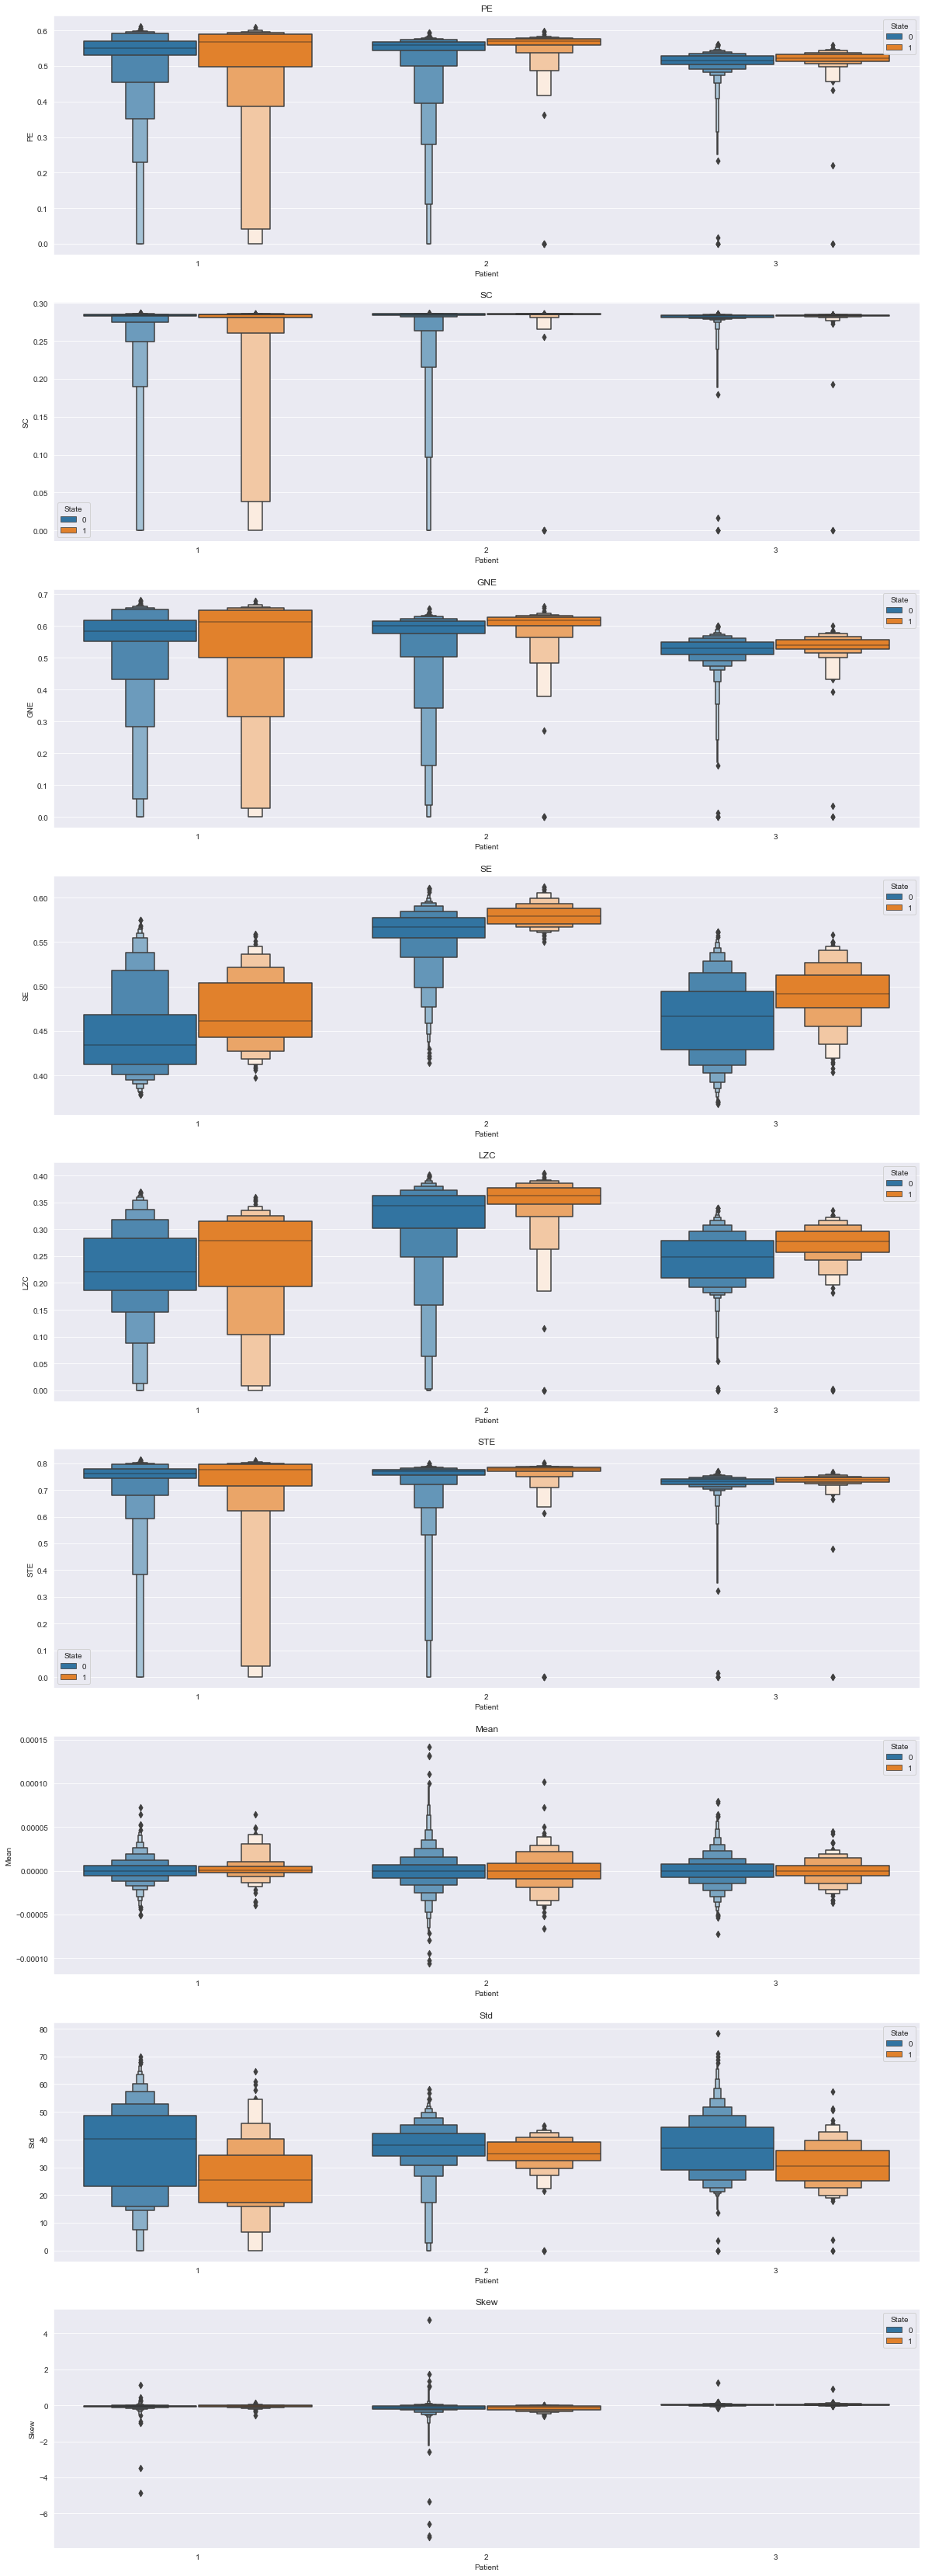

In [ ]:
from scipy import linalg
from sklearn import mixture

sns.set_style("darkgrid")

# Obtenemos los datos

df_etiquetados = []
df_no_etiquetados = []
filedir = "/home/floormolina99/DiploDatos/Mentoria/data_preprocessed"

from os import listdir

for file in listdir(filedir):
    if file[-4:] == ".csv":
        if "noEtiquetado" in file: df_no_etiquetados.append(pd.read_csv(f"{filedir}/{file}"))
        else: df_etiquetados.append(pd.read_csv(f"{filedir}/{file}"))
    else: print(file, " ---> no es csv")

for df in df_etiquetados: assert len(df.columns) == 11
for df in df_no_etiquetados: assert len(df.columns) == 10
    
df = pd.concat(df_etiquetados)

df["State"] = df["State"].astype(int)
df["Patient"] = df["Patient"].astype(int)

metricas = df.drop(axis=1, labels=["Patient", "State"]).columns

fig, axes = plt.subplots(len(metricas), figsize=(20,60))

for i,column in enumerate(metricas):
    sns.boxenplot(ax=axes[i], data=df, y=column, x="Patient", hue='State')
    axes[i].set_title(column)

for ax in axes:
    ax.tick_params(axis='y')

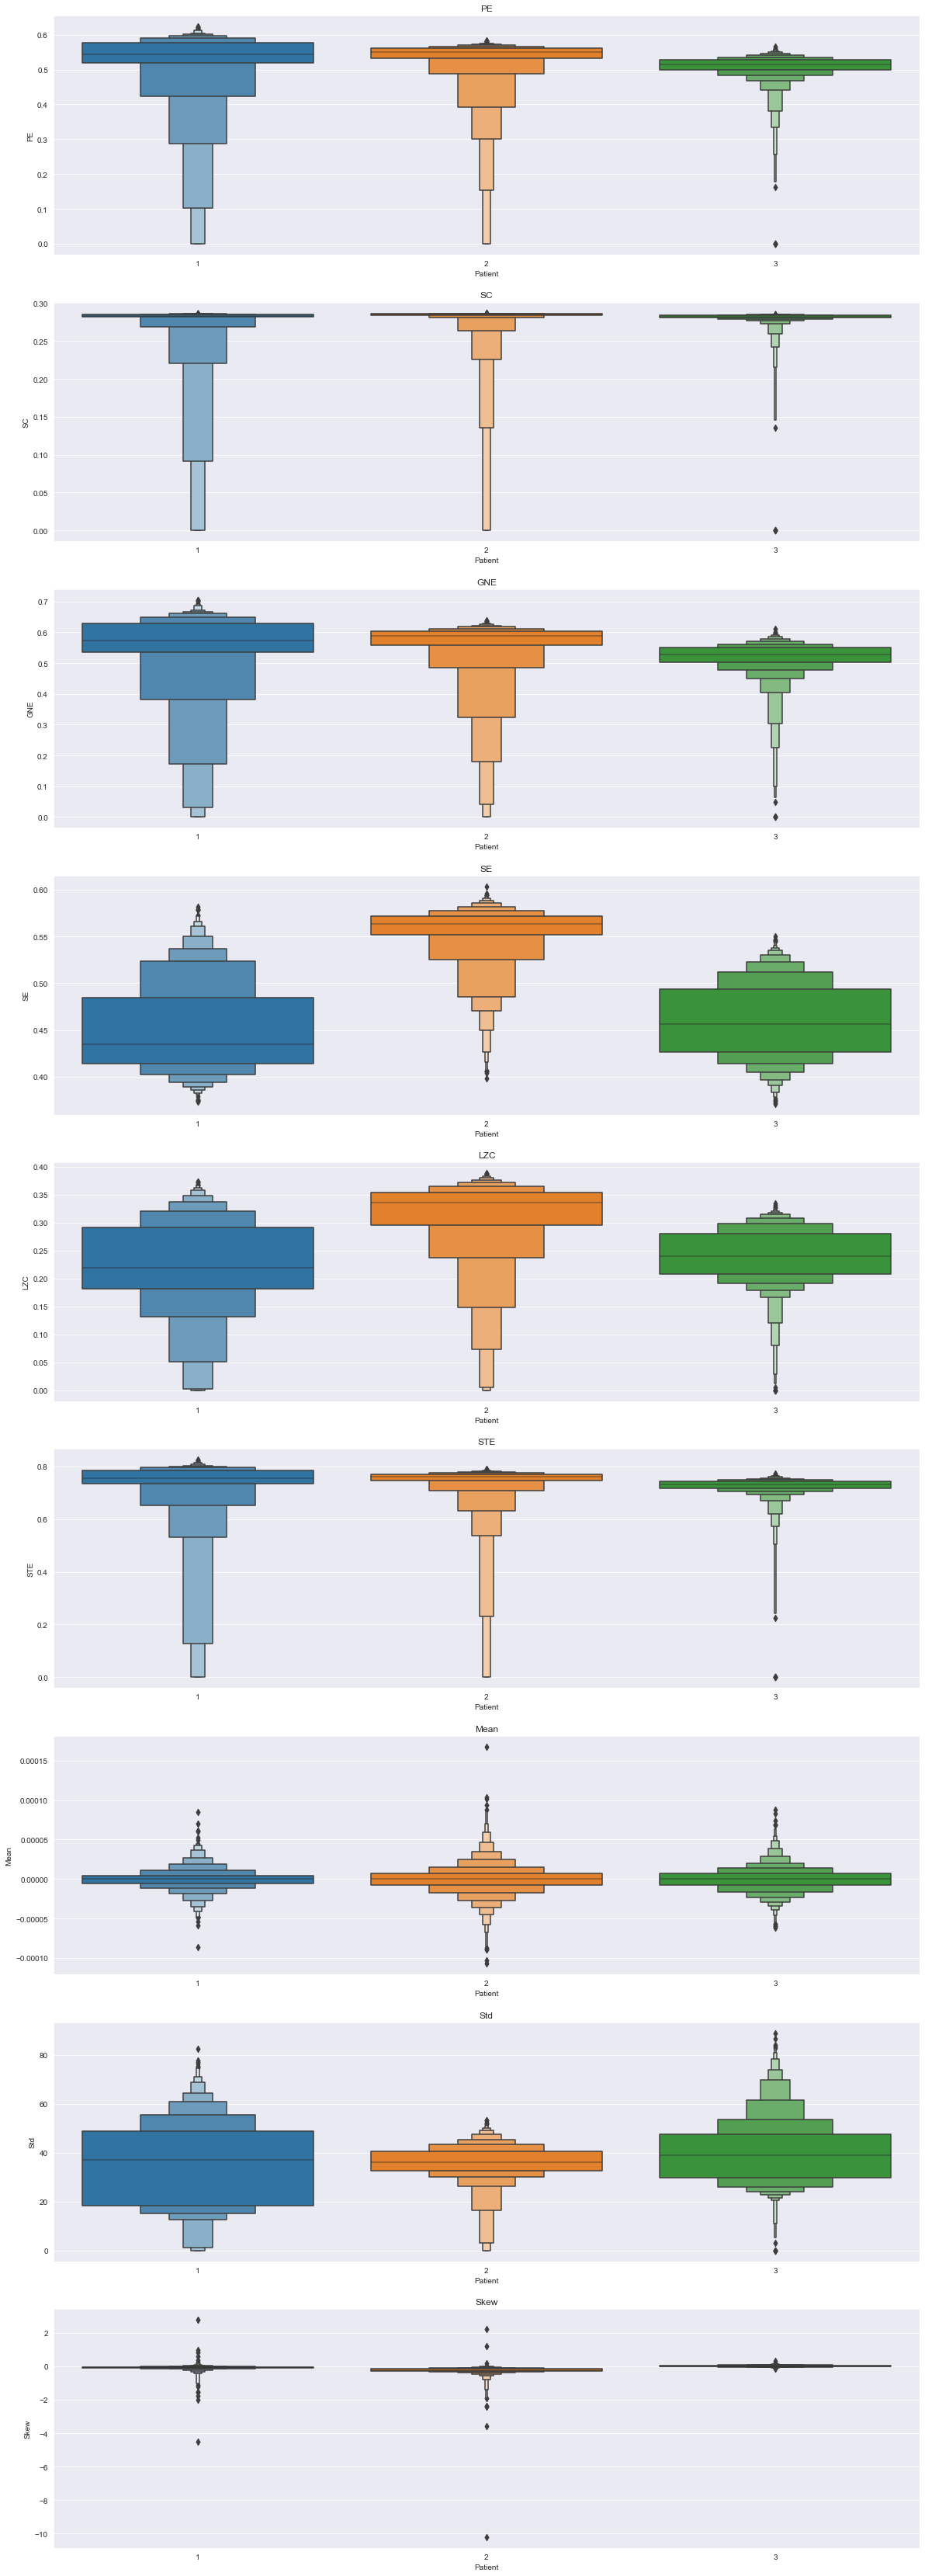

In [ ]:
df = pd.concat(df_no_etiquetados)

#df["State"] = df["State"].astype(int)
df["Patient"] = df["Patient"].astype(int)

metricas = df.drop(axis=1, labels=["Patient"]).columns

fig, axes = plt.subplots(len(metricas), figsize=(20,60))

for i,column in enumerate(metricas):
    sns.boxenplot(ax=axes[i], data=df, y=column, x="Patient")
    axes[i].set_title(column)

for ax in axes:
    ax.tick_params(axis='y')

Notemos que en general las variables no tienen una cantidad grande de outliers, sino que la mayoria de los puntos entran dentro de cada distribución. Se obsrvan también puntos que se apartan considerablemente (en algunos casos) de las distribuciones, en particular los puntos que quedan fuera de las cajas dibujadas por boxenplot. Nos aventuramos a decir que si eliminamos por cuartiles, quedarian muchos puntos afuera, ya que con boxenplot se dibujan cuartiles de orden alto, y eliminando por ejemplo los outliers por encima del cuartil 99 y por debajo del cuartil 1 por cada paciente y cada estado, nos quedaríamos con pocos datos. Optamos entonces por hacer una eliminación manual de los outliers, dado que son pocos puntos, no es dificil de determinar cotas para estos observando los gráficos de boxenplot generados y además quedarían una cantidad importante de puntos en nuestro dataframe que entran dentro de las distribuciones generadas por boxenplot y no son outliers (de acuerdo a nuestro criterio). Sabemos que este método no es generalizable a otros datasets, pero con este en particular no sería un trabajo tan largo de realizar ya que son solo 9 variables y dos estados, por lo que sería ideal aplicar esta filtración de outliers manualmente. El criterio que usamos para definir si un punto es un outlier o no consiste en ver si cae dentro de las cajas de boxenplot, si cae fuera queda eliminado. En los casos que sea dificil eliminar estos puntos (porque es dificil observar a veces en que valores terminan las cajas en los gráficos) podemos eliminar la ultima caja o puntos que forman parte de ella. 
#### Datos etiquetados

1. Paciente 1

In [ ]:
e_p1.drop(e_p1[(e_p1['Mean'] > 0.00005) & (e_p1['Mean'] < -0.00005)].index, inplace=True)
e_p1.drop(e_p1[(e_p1['Mean'] < -0.00002) & (e_p1['State'] == 1)].index, inplace=True)
e_p1.drop(e_p1[(e_p1['Std'] > 67) & (e_p1['State'] == 0)].index, inplace=True)
e_p1.drop(e_p1[(e_p1['Std'] > 56) & (e_p1['State'] == 1)].index, inplace=True)
e_p1.drop(e_p1[(e_p1['Skew'] > 1) & (e_p1['Skew'] < -1)].index, inplace=True)
e_p1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1288 entries, 0 to 1301
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  1288 non-null   float64
 1   State    1288 non-null   float64
 2   PE       1288 non-null   float64
 3   SC       1288 non-null   float64
 4   GNE      1288 non-null   float64
 5   SE       1254 non-null   float64
 6   LZC      1288 non-null   float64
 7   STE      1288 non-null   float64
 8   Mean     1288 non-null   float64
 9   Std      1288 non-null   float64
 10  Skew     1288 non-null   float64
dtypes: float64(11)
memory usage: 120.8 KB


2. Paciente 2

In [ ]:
e_p2.drop(e_p2[(e_p2['PE'] < 0.4) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['SC'] < 0.24) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['GNE'] < 0.3) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['SE'] < 0.45) & (e_p2['SE'] > 0.60) & (e_p2['State'] == 0)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['LZC'] < 0.15) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['STE'] < 0.62) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Mean'] < -0.00006) & (e_p2['Mean'] > 0.00009) & (e_p2['State'] == 0)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Mean'] < -0.00004) & (e_p2['Mean'] > 0.00005) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Std'] > 53) & (e_p2['State'] == 0)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Std'] < 20) & (e_p2['State'] == 1)].index, inplace=True)
e_p2.drop(e_p2[(e_p2['Skew'] < -2) & (e_p2['Skew'] > 1) & (e_p2['State'] == 0)].index, inplace=True)
e_p2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2332 entries, 0 to 2345
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  2332 non-null   float64
 1   State    2332 non-null   float64
 2   PE       2332 non-null   float64
 3   SC       2332 non-null   float64
 4   GNE      2332 non-null   float64
 5   SE       2304 non-null   float64
 6   LZC      2332 non-null   float64
 7   STE      2332 non-null   float64
 8   Mean     2332 non-null   float64
 9   Std      2332 non-null   float64
 10  Skew     2332 non-null   float64
dtypes: float64(11)
memory usage: 218.6 KB


3. Paciente 3

In [ ]:
e_p3.groupby('State').max()

,Patient,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
State,,,,,,,,,,
0.0,3.0,0.560514,0.285814,0.601137,0.561995,0.340070,0.769287,0.000080,78.387501,1.235742
1.0,3.0,0.559118,0.285550,0.599388,0.558377,0.334796,0.768390,0.000045,57.309414,0.927300


In [ ]:
e_p3.drop(e_p3[(e_p3['PE'] < 0.3) & (e_p3['State'] == 0)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['PE'] < 0.45) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['SC'] < 0.20)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['GNE'] < 0.2) & (e_p3['State'] == 0)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['GNE'] < 0.4) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['SE'] > 0.55)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['SE'] < 0.42) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['LZC'] < 0.10)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['STE'] < 0.5)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Mean'] < -0.00005) & (e_p3['Mean'] > 0.00005)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Std'] < 10) & (e_p3['Std'] > 65) & (e_p3['State'] == 0)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Std'] < 19) & (e_p3['Std'] > 46) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Skew'] == 1.235742) & (e_p3['State'] == 0)].index, inplace=True)
e_p3.drop(e_p3[(e_p3['Skew'] == 0.927300) & (e_p3['State'] == 1)].index, inplace=True)
e_p3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2393
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  2356 non-null   float64
 1   State    2356 non-null   float64
 2   PE       2356 non-null   float64
 3   SC       2356 non-null   float64
 4   GNE      2356 non-null   float64
 5   SE       2356 non-null   float64
 6   LZC      2356 non-null   float64
 7   STE      2356 non-null   float64
 8   Mean     2356 non-null   float64
 9   Std      2356 non-null   float64
 10  Skew     2356 non-null   float64
dtypes: float64(11)
memory usage: 220.9 KB


#### Datos no etiquetados

1. Paciente 1

In [ ]:
ne_p1.drop(ne_p1[(ne_p1['Mean'] > 0.00005) & (ne_p1['Mean'] < -0.00005)].index, inplace=True)
ne_p1.drop(ne_p1[(ne_p1['Std'] > 75)].index, inplace=True)
ne_p1.drop(ne_p1[(ne_p1['Skew'] > 1) & (ne_p1['Skew'] < -1)].index, inplace=True)
ne_p1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1578 entries, 0 to 1582
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  1578 non-null   float64
 1   PE       1578 non-null   float64
 2   SC       1578 non-null   float64
 3   GNE      1578 non-null   float64
 4   SE       1531 non-null   float64
 5   LZC      1578 non-null   float64
 6   STE      1578 non-null   float64
 7   Mean     1578 non-null   float64
 8   Std      1578 non-null   float64
 9   Skew     1578 non-null   float64
dtypes: float64(10)
memory usage: 135.6 KB


2. Paciente 2

In [ ]:
ne_p2.drop(ne_p2[(ne_p2['SE'] > 0.60) & (ne_p2['SE'] < 0.41)].index, inplace=True)
ne_p2.drop(ne_p2[(ne_p2['Mean'] > 0.0008) & (ne_p2['Mean'] < -0.00010)].index, inplace=True)
ne_p2.drop(ne_p2[(ne_p2['Skew'] > 1) & (ne_p2['Skew'] < -1)].index, inplace=True)
ne_p2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2255 entries, 0 to 2254
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  2255 non-null   float64
 1   PE       2255 non-null   float64
 2   SC       2255 non-null   float64
 3   GNE      2255 non-null   float64
 4   SE       2226 non-null   float64
 5   LZC      2255 non-null   float64
 6   STE      2255 non-null   float64
 7   Mean     2255 non-null   float64
 8   Std      2255 non-null   float64
 9   Skew     2255 non-null   float64
dtypes: float64(10)
memory usage: 176.3 KB


3. Paciente 3

In [ ]:
ne_p3.drop(ne_p3[(ne_p3['PE'] < 0.2)].index, inplace=True)
ne_p3.drop(ne_p3[(ne_p3['SC'] < 0.15)].index, inplace=True)
ne_p3.drop(ne_p3[(ne_p3['GNE'] > 0.6) & (ne_p3['Mean'] < 0.06)].index, inplace=True)
ne_p3.drop(ne_p3[(ne_p3['STE'] < 0.22)].index, inplace=True)
ne_p3.drop(ne_p3[(ne_p3['Mean'] > 0.00005) & (ne_p3['Mean'] < -0.00005)].index, inplace=True)
ne_p3.drop(ne_p3[(ne_p3['Skew'] > 1) & (ne_p3['Skew'] < -1)].index, inplace=True)
ne_p3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2273 entries, 0 to 2280
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  2273 non-null   float64
 1   PE       2273 non-null   float64
 2   SC       2273 non-null   float64
 3   GNE      2273 non-null   float64
 4   SE       2273 non-null   float64
 5   LZC      2273 non-null   float64
 6   STE      2273 non-null   float64
 7   Mean     2273 non-null   float64
 8   Std      2273 non-null   float64
 9   Skew     2273 non-null   float64
dtypes: float64(10)
memory usage: 195.3 KB


Ahora unimos todos los dataframes filtrados por outliers y dividimos en etiquetados y no etiquetados

In [ ]:
etiquetados = pd.concat([e_p1,e_p2,e_p3]).reset_index(drop=True)
etiquetados = etiquetados.sample(frac=1)
etiquetados = etiquetados.reset_index(drop=True)
print(len(etiquetados.index))
etiquetados.head()

5976


,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,2.0,0.0,0.550907,0.285862,0.588193,0.573588,0.351380,0.763177,-5.674441e-05,34.568613,-0.289305
1,2.0,0.0,0.579114,0.285562,0.632426,0.587729,0.377630,0.786444,-9.443724e-07,33.976990,-0.069432
2,3.0,0.0,0.520805,0.281732,0.536466,0.390514,0.195482,0.735581,-4.759490e-06,40.983959,-0.012463
3,3.0,0.0,0.510568,0.279757,0.518720,0.375995,0.175450,0.726481,-6.652268e-06,50.463843,-0.022853
4,2.0,0.0,0.532496,0.284383,0.557970,0.546695,0.303072,0.747219,-3.826969e-06,41.365546,-0.235055


In [ ]:
no_etiquetados = pd.concat([ne_p1,ne_p2,ne_p3]).reset_index(drop=True)
no_etiquetados = no_etiquetados.sample(frac=1)
no_etiquetados = no_etiquetados.reset_index(drop=True)
print(len(no_etiquetados.index))
no_etiquetados.head()

6106


,Patient,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,3.0,0.534463,0.284065,0.560098,0.480094,0.277138,0.748023,0.000005,35.080886,0.108078
1,3.0,0.533094,0.284164,0.558522,0.518472,0.298055,0.746946,0.000009,25.783075,-0.028732
2,1.0,0.509407,0.281190,0.518206,0.416022,0.176027,0.726269,0.000044,68.678322,-0.093695
3,3.0,0.507842,0.282099,0.516775,0.497477,0.240010,0.725652,-0.000029,27.895174,0.007374
4,2.0,0.538457,0.284781,0.567593,0.551371,0.312544,0.752103,0.000014,41.041515,-0.232043


Volvemos a hacer la filtración que hicimos en el ejercicio 1 para quitar datos nulos, ya que como aca trabajamos con todos los dataframes por separado no está hecha la eliminación de datos nulos que hicimos en el ejercicio anterior. 

In [ ]:
etiquetados = etiquetados.dropna(axis=0)
print(len(etiquetados.index))
etiquetados.head()

5914


,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,2.0,0.0,0.550907,0.285862,0.588193,0.573588,0.351380,0.763177,-5.674441e-05,34.568613,-0.289305
1,2.0,0.0,0.579114,0.285562,0.632426,0.587729,0.377630,0.786444,-9.443724e-07,33.976990,-0.069432
2,3.0,0.0,0.520805,0.281732,0.536466,0.390514,0.195482,0.735581,-4.759490e-06,40.983959,-0.012463
3,3.0,0.0,0.510568,0.279757,0.518720,0.375995,0.175450,0.726481,-6.652268e-06,50.463843,-0.022853
4,2.0,0.0,0.532496,0.284383,0.557970,0.546695,0.303072,0.747219,-3.826969e-06,41.365546,-0.235055


In [ ]:
etiquetados.isnull().sum()

Patient    0
State      0
PE         0
SC         0
GNE        0
SE         0
LZC        0
STE        0
Mean       0
Std        0
Skew       0
dtype: int64

In [ ]:
etiquetados.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5914 entries, 0 to 5975
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  5914 non-null   float64
 1   State    5914 non-null   float64
 2   PE       5914 non-null   float64
 3   SC       5914 non-null   float64
 4   GNE      5914 non-null   float64
 5   SE       5914 non-null   float64
 6   LZC      5914 non-null   float64
 7   STE      5914 non-null   float64
 8   Mean     5914 non-null   float64
 9   Std      5914 non-null   float64
 10  Skew     5914 non-null   float64
dtypes: float64(11)
memory usage: 554.4 KB


In [ ]:
no_etiquetados = no_etiquetados.dropna(axis=0)
print(len(no_etiquetados.index))
no_etiquetados.head()

6030


,Patient,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,3.0,0.534463,0.284065,0.560098,0.480094,0.277138,0.748023,0.000005,35.080886,0.108078
1,3.0,0.533094,0.284164,0.558522,0.518472,0.298055,0.746946,0.000009,25.783075,-0.028732
2,1.0,0.509407,0.281190,0.518206,0.416022,0.176027,0.726269,0.000044,68.678322,-0.093695
3,3.0,0.507842,0.282099,0.516775,0.497477,0.240010,0.725652,-0.000029,27.895174,0.007374
4,2.0,0.538457,0.284781,0.567593,0.551371,0.312544,0.752103,0.000014,41.041515,-0.232043


Hemos descartado 128 datos etiquetados y 89 no etiquetados, lo cual esta bastante bien porque es un porcentaje bajo de datos que tuvimos que eliminar para no tener outliers ni datos nulos

--------------------
### Ejercicio 4: Escalado
Hacemos escalado sobre los datos etiquetados y no etiquetados, y sobre las etiquetas LZE, media, varianza y skew utilizando MinMaxScaler de Scikit-learn

In [ ]:
from sklearn.preprocessing import MinMaxScaler

X_etiquetados = etiquetados.iloc[:,[6,8,9,10]]
scaler = MinMaxScaler()
X_etiquetados_scale = scaler.fit_transform(X_etiquetados)
X_etiquetados_scale = pd.DataFrame(X_etiquetados_scale, columns=['LZC', 'Mean', 'Std', 'Skew'])
#X_etiquetados_scale.info()
etiquetados_drop = etiquetados.drop(['LZC','Mean','Std','Skew'], axis=1, inplace=False)
#etiquetados_drop.info()
etiquetados_drop.reset_index(drop=True, inplace=True)
X_etiquetados_scale.reset_index(drop=True, inplace=True)
etiquetados_scale = pd.DataFrame(pd.concat([etiquetados_drop, X_etiquetados_scale], axis=1), columns=etiquetados.columns)
etiquetados_scale
#type(X_etiquetados_scale)

,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,2.0,0.0,0.550907,0.285862,0.588193,0.573588,0.868998,0.763177,0.199807,0.437886,0.582735
1,2.0,0.0,0.579114,0.285562,0.632426,0.587729,0.934147,0.786444,0.424548,0.430296,0.600991
2,3.0,0.0,0.520805,0.281732,0.536466,0.390514,0.482090,0.735581,0.409182,0.520183,0.605721
3,3.0,0.0,0.510568,0.279757,0.518720,0.375995,0.432373,0.726481,0.401559,0.641792,0.604859
4,2.0,0.0,0.532496,0.284383,0.557970,0.546695,0.749108,0.747219,0.412938,0.525078,0.587239
...,...,...,...,...,...,...,...,...,...,...,...
5909,2.0,0.0,0.214954,0.166286,0.192955,0.573505,0.221344,0.279222,0.365514,0.234066,0.616436
5910,2.0,1.0,0.570442,0.285305,0.618538,0.575978,0.897079,0.779011,0.319520,0.490988,0.605519
5911,2.0,0.0,0.558349,0.284905,0.599257,0.557140,0.842014,0.768707,0.322228,0.554732,0.582432
5912,2.0,0.0,0.552440,0.283860,0.588150,0.476182,0.614744,0.762700,0.380321,0.623727,0.609454


In [ ]:
X_netiquetados = no_etiquetados.iloc[:,[5,7,8,9]]
scaler = MinMaxScaler()
X_netiquetados_scale = scaler.fit_transform(X_netiquetados)
X_netiquetados_scale = pd.DataFrame(X_netiquetados_scale, columns=['LZC', 'Mean', 'Std', 'Skew'])
#X_etiquetados_scale.info()
netiquetados_drop = no_etiquetados.drop(['LZC','Mean','Std','Skew'], axis=1, inplace=False)
#etiquetados_drop.info()
netiquetados_drop.reset_index(drop=True, inplace=True)
X_netiquetados_scale.reset_index(drop=True, inplace=True)
no_etiquetados_scale = pd.DataFrame(pd.concat([netiquetados_drop, X_netiquetados_scale], axis=1), columns=no_etiquetados.columns)
no_etiquetados_scale

,Patient,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew
0,3.0,0.534463,0.284065,0.560098,0.480094,0.712673,0.748023,0.406593,0.392557,0.794887
1,3.0,0.533094,0.284164,0.558522,0.518472,0.766716,0.746946,0.424404,0.287392,0.784346
2,1.0,0.509407,0.281190,0.518206,0.416022,0.451429,0.726269,0.548180,0.772567,0.779340
3,3.0,0.507842,0.282099,0.516775,0.497477,0.616744,0.725652,0.282962,0.311282,0.787128
4,2.0,0.538457,0.284781,0.567593,0.551371,0.804151,0.752103,0.439073,0.459976,0.768680
...,...,...,...,...,...,...,...,...,...,...
6025,1.0,0.586020,0.285585,0.642910,0.527143,0.842669,0.791856,0.409353,0.191871,0.782923
6026,3.0,0.528028,0.284303,0.550703,0.513424,0.767341,0.743106,0.309914,0.306506,0.786536
6027,3.0,0.533616,0.284049,0.558735,0.496645,0.743494,0.747144,0.371909,0.377152,0.786541
6028,1.0,0.581872,0.285178,0.635525,0.458947,0.769938,0.787852,0.347365,0.291965,0.787453


--------------------------
### Ejercicio 3: balanceo de etiquetas

Elegimos RandomOverSampler, SMOTE y ADASYN para hacer over-sampling y elegimos ClusterCentroids, RandomUnderSampler y NearMiss para hacer under-sampling, todos estos de ImbalancedLearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SMOTE, ADASYN

X = etiquetados_scale.iloc[:, [0,2,3,4,5,6,7,8,9]]
Y = etiquetados_scale.iloc[:, 1]
#X_etiquetados = etiquetados_scale['PE','SC','GNE','SE','LZC','STE','Mean','Std','Skew']
#Y_etiquetados = etiquetados_scale['State']
print(len(X))
print(len(Y))
print(Y)

5914
5914
0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
5909    0.0
5910    1.0
5911    0.0
5912    0.0
5913    0.0
Name: State, Length: 5914, dtype: float64


In [ ]:
def plot_resampling(X, y, sampler, ax, title=None):
    X_res, y_res = sampler.fit_resample(X, y)
    ax.scatter(X_res[:, 0], X_res[:, 1], c=y_res, alpha=0.8, edgecolor="k")
    if title is None:
        title = f"Resampling with {sampler.__class__.__name__}"
    ax.set_title(title)
    sns.despine(ax=ax, offset=10)

### Over-sampling
1. RandomOverSampler

In [ ]:
ros = RandomOverSampler(random_state=0)
X_random, y_random = ros.fit_resample(X, Y)
etiquetados_balanceados_random = pd.DataFrame(pd.concat([X_random, y_random], axis=1), columns=etiquetados_scale.columns)
etiquetados_balanceados_random.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10996 entries, 0 to 10995
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  10996 non-null  float64
 1   State    10996 non-null  float64
 2   PE       10996 non-null  float64
 3   SC       10996 non-null  float64
 4   GNE      10996 non-null  float64
 5   SE       10996 non-null  float64
 6   LZC      10996 non-null  float64
 7   STE      10996 non-null  float64
 8   Mean     10996 non-null  float64
 9   Std      10996 non-null  float64
 10  Skew     0 non-null      float64
dtypes: float64(11)
memory usage: 945.1 KB


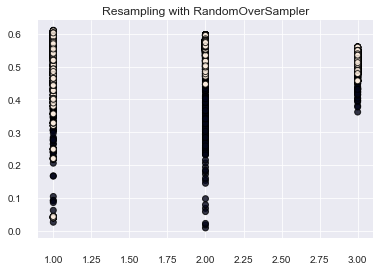

In [ ]:
fig, ax = plt.subplots() 
plot_resampling(X.values,Y.values,ros,ax,title=None)

In [ ]:
etiquetados_balanceados_random.to_csv(r'/home/floormolina99/DiploDatos/Mentoria/data_balanced/etiquetados_balanceados_random.csv',
                                      index=False)

2. SMOTE

In [ ]:
smote = SMOTE(random_state=0)
X_smote, y_smote = smote.fit_resample(X, Y)
etiquetados_balanceados_smote = pd.DataFrame(pd.concat([X_smote, y_smote], axis=1), columns=etiquetados_scale.columns)
etiquetados_balanceados_smote.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10996 entries, 0 to 10995
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  10996 non-null  float64
 1   State    10996 non-null  float64
 2   PE       10996 non-null  float64
 3   SC       10996 non-null  float64
 4   GNE      10996 non-null  float64
 5   SE       10996 non-null  float64
 6   LZC      10996 non-null  float64
 7   STE      10996 non-null  float64
 8   Mean     10996 non-null  float64
 9   Std      10996 non-null  float64
 10  Skew     0 non-null      float64
dtypes: float64(11)
memory usage: 945.1 KB


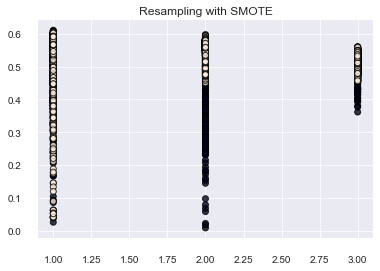

In [ ]:
fig, ax = plt.subplots() 
plot_resampling(X.values,Y.values,smote,ax,title=None)

In [ ]:
etiquetados_balanceados_smote.to_csv(r'/home/floormolina99/DiploDatos/Mentoria/data_balanced/etiquetados_balanceados_smote.csv',
                                      index=False)

3. ADASYN

In [ ]:
adasyn = ADASYN(random_state=0)
X_adasyn, y_adasyn = adasyn.fit_resample(X, Y)
etiquetados_balanceados_adasyn = pd.DataFrame(pd.concat([X_adasyn, y_adasyn], axis=1), columns=etiquetados_scale.columns)
etiquetados_balanceados_adasyn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10941 entries, 0 to 10940
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  10941 non-null  float64
 1   State    10941 non-null  float64
 2   PE       10941 non-null  float64
 3   SC       10941 non-null  float64
 4   GNE      10941 non-null  float64
 5   SE       10941 non-null  float64
 6   LZC      10941 non-null  float64
 7   STE      10941 non-null  float64
 8   Mean     10941 non-null  float64
 9   Std      10941 non-null  float64
 10  Skew     0 non-null      float64
dtypes: float64(11)
memory usage: 940.4 KB


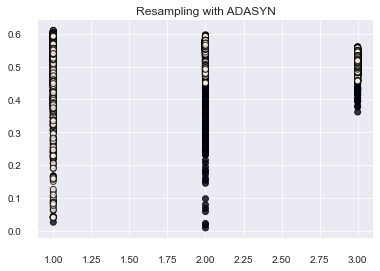

In [ ]:
fig, ax = plt.subplots() 
plot_resampling(X.values,Y.values,adasyn,ax,title=None)

In [ ]:
etiquetados_balanceados_adasyn.to_csv(r'/home/floormolina99/DiploDatos/Mentoria/data_balanced/etiquetados_balanceados_adasyn.csv',
                                      index=False)

### Under-sampling

In [ ]:
from imblearn.under_sampling import ClusterCentroids
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NearMiss

1. Cluster centroids

In [ ]:
cluster_c = ClusterCentroids(random_state=0)
X_cluster, y_cluster = cluster_c.fit_resample(X, Y)
etiquetados_balanceados_cluster = pd.DataFrame(pd.concat([X_cluster, y_cluster], axis=1), columns=etiquetados_scale.columns)
etiquetados_balanceados_cluster.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  832 non-null    float64
 1   State    832 non-null    float64
 2   PE       832 non-null    float64
 3   SC       832 non-null    float64
 4   GNE      832 non-null    float64
 5   SE       832 non-null    float64
 6   LZC      832 non-null    float64
 7   STE      832 non-null    float64
 8   Mean     832 non-null    float64
 9   Std      832 non-null    float64
 10  Skew     0 non-null      float64
dtypes: float64(11)
memory usage: 71.6 KB


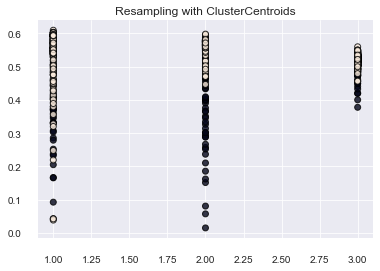

In [ ]:
fig, ax = plt.subplots() 
plot_resampling(X.values,Y.values,cluster_c,ax,title=None)

In [ ]:
etiquetados_balanceados_cluster.to_csv(r'/home/floormolina99/DiploDatos/Mentoria/data_balanced/etiquetados_balanceados_cluster.csv',
                                      index=False)

2. Random Under Sampler

In [ ]:
random_u = RandomUnderSampler(random_state=0)
X_random_u, y_random_u = random_u.fit_resample(X, Y)
etiquetados_balanceados_random_u = pd.DataFrame(pd.concat([X_random_u, y_random_u], axis=1), columns=etiquetados_scale.columns)
etiquetados_balanceados_random_u.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  832 non-null    float64
 1   State    832 non-null    float64
 2   PE       832 non-null    float64
 3   SC       832 non-null    float64
 4   GNE      832 non-null    float64
 5   SE       832 non-null    float64
 6   LZC      832 non-null    float64
 7   STE      832 non-null    float64
 8   Mean     832 non-null    float64
 9   Std      832 non-null    float64
 10  Skew     0 non-null      float64
dtypes: float64(11)
memory usage: 71.6 KB


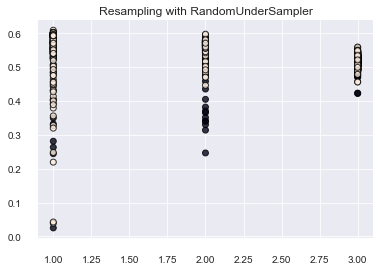

In [ ]:
fig, ax = plt.subplots() 
plot_resampling(X.values,Y.values,random_u,ax,title=None)

In [ ]:
etiquetados_balanceados_random_u.to_csv(r'/home/floormolina99/DiploDatos/Mentoria/data_balanced/etiquetados_balanceados_random_u.csv',
                                      index=False)

3. Near Miss (primera version)

In [ ]:
near = NearMiss(version=1)
X_near, y_near = near.fit_resample(X, Y)
etiquetados_balanceados_near = pd.DataFrame(pd.concat([X_near, y_near], axis=1), columns=etiquetados_scale.columns)
etiquetados_balanceados_near.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 832 entries, 0 to 831
Data columns (total 11 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Patient  832 non-null    float64
 1   State    832 non-null    float64
 2   PE       832 non-null    float64
 3   SC       832 non-null    float64
 4   GNE      832 non-null    float64
 5   SE       832 non-null    float64
 6   LZC      832 non-null    float64
 7   STE      832 non-null    float64
 8   Mean     832 non-null    float64
 9   Std      832 non-null    float64
 10  Skew     0 non-null      float64
dtypes: float64(11)
memory usage: 71.6 KB


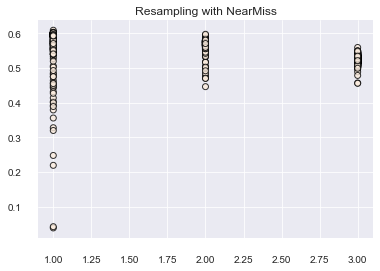

In [ ]:
fig, ax = plt.subplots() 
plot_resampling(X.values,Y.values,near,ax,title=None)

In [ ]:
etiquetados_balanceados_near.to_csv(r'/home/floormolina99/DiploDatos/Mentoria/data_balanced/etiquetados_balanceados_near.csv',
                                      index=False)

### Ejercicio 5: PCA
Para hacer PCA, ademas de escalar o normalizar los datos (que es lo que ya hicimos) tenemos que correr la media de cada una de las features a cero, lo cual no se logra utilizando solamente MinMaxScaler. Por lo tanto, aplicamos StandardScaler sobre los datos ya escalados. 

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

etiquetados_sin_features = etiquetados_scale.iloc[:, [0,2,3,4,5,6,7,8,9,10]]
scaled_data = StandardScaler().fit_transform(etiquetados_sin_features)

pca = PCA()
pca.fit(scaled_data)
pca_data = pca.transform(scaled_data)

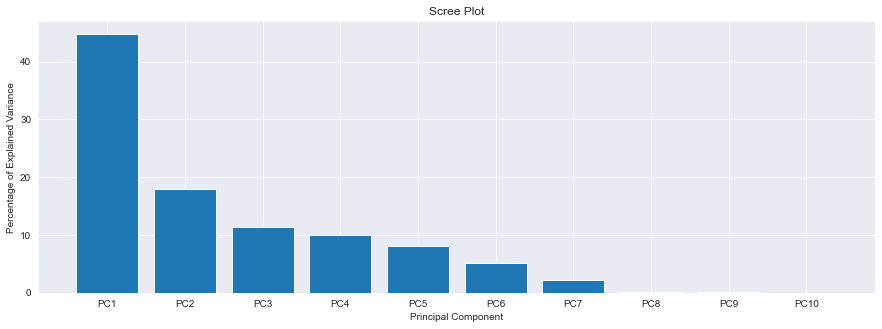

In [ ]:
per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)]
 
fig = plt.figure(figsize=(15,5))    
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

Las componentes mas significativas son hasta la PC7, asi que sumamos hasta esta componente al dataframe de datos escalados.

Ploteamos las primeras dos componentes haciendo hue por estados, solo para ver como se distribuyen o varian los datos en estas dos componentes y con cada clase.

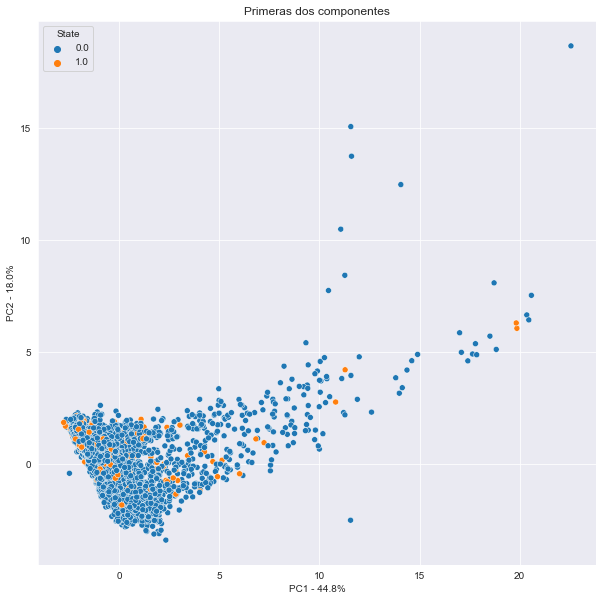

In [ ]:
pca_df = pd.DataFrame(pca_data, index=range(5914), columns=labels)
solo_pca_etiquetados = pca_df.join(etiquetados_scale['State'])

fig = plt.figure(figsize=(10,10))  
colors = {'0':'blue', '1':'orange'}
sns.scatterplot(x='PC1', y='PC2', data=solo_pca_etiquetados, hue='State')
plt.title('Primeras dos componentes')
plt.xlabel('PC1 - {0}%'.format(per_var[0]))
plt.ylabel('PC2 - {0}%'.format(per_var[1]))
 
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
 
plt.show()

Sabemos que PCA refleja las componentes de mayor varianza en el conjunto de datos, y observamos que si bien no se han separado las clases en clusters, los datos varian mucho a lo largo de PC1 (como es esperable, ya que PC1 sola lleva casi el 45% de la varianza). Tambien vemos que a lo largo de PC1 las dos clases muestran un patrón de separaciones similares en sus datos. Se observan algunos puntos aislados a lo largo de PC2. Observamos, por último, una gran concentración de puntos (más que nada en el estado 0) en el origen del gráfico. 

Finalmente, unimos nuestro dataframe original (escalado y curado) con las primeras 7 componentes principales, que son las que más aportan a la varianza de los datos. 

In [ ]:
principales = pca_df.iloc[:,0:7]
pca_etiquetados = etiquetados_scale.join(principales)
pca_etiquetados

,Patient,State,PE,SC,GNE,SE,LZC,STE,Mean,Std,Skew,PC1,PC2,PC3,PC4,PC5,PC6,PC7
0,2.0,0.0,0.550907,0.285862,0.588193,0.573588,0.868998,0.763177,0.199807,0.437886,0.582735,-1.328977,1.419806,0.029579,-3.483097,0.424608,-0.230394,-0.119241
1,2.0,0.0,0.579114,0.285562,0.632426,0.587729,0.934147,0.786444,0.424548,0.430296,0.600991,-2.134161,1.232852,-0.157240,0.002282,-0.111780,-0.546110,0.113972
2,3.0,0.0,0.520805,0.281732,0.536466,0.390514,0.482090,0.735581,0.409182,0.520183,0.605721,0.952135,-1.809801,-0.470347,-0.313300,0.408602,0.837827,0.496929
3,3.0,0.0,0.510568,0.279757,0.518720,0.375995,0.432373,0.726481,0.401559,0.641792,0.604859,1.358155,-2.460955,-0.140864,-0.483246,0.768440,0.315985,0.447793
4,2.0,0.0,0.532496,0.284383,0.557970,0.546695,0.749108,0.747219,0.412938,0.525078,0.587239,-0.507365,0.564942,0.481208,-0.293394,0.616303,-0.472068,-0.298097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5909,2.0,0.0,0.214954,0.166286,0.192955,0.573505,0.221344,0.279222,0.365514,0.234066,0.616436,11.573135,3.967700,-1.184374,-0.904529,-2.032794,-3.109050,1.505916
5910,2.0,1.0,0.570442,0.285305,0.618538,0.575978,0.897079,0.779011,0.319520,0.490988,0.605519,-1.869505,0.768460,-0.242157,-1.599806,-0.173483,-0.846387,0.021265
5911,2.0,0.0,0.558349,0.284905,0.599257,0.557140,0.842014,0.768707,0.322228,0.554732,0.582432,-1.364562,0.698472,0.541555,-1.676881,0.817995,-0.645941,0.025719
5912,2.0,0.0,0.552440,0.283860,0.588150,0.476182,0.614744,0.762700,0.380321,0.623727,0.609454,-0.513315,-1.228818,0.432971,-0.774483,-0.065376,-0.538379,0.091189
